# Import

In [9]:
import pandas as pd
import os
import numpy as np
from datetime import datetime, timedelta
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
import pandas_gbq

# Import Data

In [10]:
project_id = "rental-price-prediction"
query_landed = """
SELECT * FROM ura_data.landed_data;
"""
query_nonlanded = """
SELECT * FROM ura_data.nonlanded_data;
"""
landed = pandas_gbq.read_gbq(query_landed, project_id=project_id, dialect="standard") # Terrace House, Detached House, Semi-Detached House
nonlanded = pandas_gbq.read_gbq(query_nonlanded, project_id=project_id, dialect="standard") # Non-landed Properties, Executive Condominium

Downloading: 100%|██████████|
Downloading: 100%|██████████|


In [11]:
landed

,leaseDate,propertyType,district,rent,street,x,y,project,refPeriod,areaSqft_formatted,leaseYear,leaseQuarter,leaseMonth,num_bus_stops
0,2022-06-01 00:00:00+00:00,Semi-Detached House,26,3800.0,SPRINGLEAF AVENUE,26622.43750,42394.43047,SPRINGLEAF GARDEN,2022Q2,3750.0,2022,2,6,0.0
1,2022-06-01 00:00:00+00:00,Semi-Detached House,14,6000.0,LORONG 20 GEYLANG,33344.05669,32555.51002,LANDED HOUSING DEVELOPMENT,2022Q2,2250.0,2022,2,6,4.0
2,2022-06-01 00:00:00+00:00,Semi-Detached House,14,6000.0,LORONG 20 GEYLANG,33344.05669,32555.51002,LANDED HOUSING DEVELOPMENT,2022Q2,2250.0,2022,2,6,4.0
3,2022-06-01 00:00:00+00:00,Terrace House,05,3500.0,PASIR PANJANG ROAD,20896.61919,30560.79783,LANDED HOUSING DEVELOPMENT,2022Q2,1750.0,2022,2,6,9.0
4,2022-06-01 00:00:00+00:00,Terrace House,05,2500.0,PASIR PANJANG ROAD,20896.61919,30560.79783,LANDED HOUSING DEVELOPMENT,2022Q2,1750.0,2022,2,6,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20153,2021-10-01 00:00:00+00:00,Terrace House,14,3700.0,LORONG 36 GEYLANG,34132.23508,32732.61046,LANDED HOUSING DEVELOPMENT,2021Q4,1000.0,2021,4,10,5.0
20154,2021-10-01 00:00:00+00:00,Terrace House,19,7500.0,COURT ROAD,31840.11436,39089.32025,LANDED HOUSING DEVELOPMENT,2021Q4,1750.0,2021,4,10,2.0
20155,2021-10-01 00:00:00+00:00,Terrace House,19,7500.0,COURT ROAD,31840.11436,39089.32025,LANDED HOUSING DEVELOPMENT,2021Q4,1750.0,2021,4,10,2.0
20156,2021-10-01 00:00:00+00:00,Terrace House,09,4800.0,JALAN JINTAN,28190.61173,31987.88269,KIMSIA PARK,2021Q4,1750.0,2021,4,10,4.0


In [12]:
nonlanded

,leaseDate,propertyType,district,noOfBedRoom,rent,street,x,y,project,refPeriod,areaSqft_formatted,leaseYear,leaseQuarter,leaseMonth,num_bus_stops,median
0,2021-01-01 00:00:00+00:00,Non-landed Properties,09,4,9000.0,LLOYD ROAD,28666.83421,31027.61664,THE BOTANIC ON LLOYD,2021Q1,2650.0,2021,1,1,2.0,3.018868
1,2021-03-01 00:00:00+00:00,Non-landed Properties,09,3,7200.0,LLOYD ROAD,28666.83421,31027.61664,THE BOTANIC ON LLOYD,2021Q1,1850.0,2021,1,3,2.0,4.324324
2,2021-01-01 00:00:00+00:00,Non-landed Properties,09,3,6200.0,LLOYD ROAD,28666.83421,31027.61664,THE BOTANIC ON LLOYD,2021Q1,1850.0,2021,1,1,2.0,4.324324
3,2021-02-01 00:00:00+00:00,Non-landed Properties,09,3,6500.0,LLOYD ROAD,28666.83421,31027.61664,THE BOTANIC ON LLOYD,2021Q1,1550.0,2021,1,2,2.0,5.161290
4,2021-02-01 00:00:00+00:00,Executive Condominium,28,3,1500.0,FERNVALE LANE,32278.99046,41156.03322,THE TOPIARY,2021Q1,1250.0,2021,1,2,8.0,2.560000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237165,2023-10-01 00:00:00+00:00,Non-landed Properties,14,3,6000.0,LORONG 27A GEYLANG,33688.56721,32954.02840,SIMS GREEN,2023Q4,1250.0,2023,4,10,3.0,4.000000
237166,2023-11-01 00:00:00+00:00,Non-landed Properties,14,3,4750.0,LORONG 27A GEYLANG,33688.56721,32954.02840,SIMS GREEN,2023Q4,1250.0,2023,4,11,3.0,4.000000
237167,2023-12-01 00:00:00+00:00,Non-landed Properties,14,3,4700.0,LORONG 27A GEYLANG,33688.56721,32954.02840,SIMS GREEN,2023Q4,1250.0,2023,4,12,3.0,4.000000
237168,2023-10-01 00:00:00+00:00,Non-landed Properties,15,1,2700.0,EAST COAST ROAD,36816.96074,32405.15612,HERITAGE EAST,2023Q4,350.0,2023,4,10,8.0,7.714286


# One Hot Encoding

In [13]:
def encode_df(df):
    """ one hot encoding of features district and propertyType, first category dropped"""
    df['district'] = df['district'].astype('category')
    df['propertyType'] = df['propertyType'].astype('category')
    df = pd.get_dummies(df, columns=["district", "propertyType"], drop_first=True)
    return df

landed_encoded = encode_df(landed)
nonlanded_encoded = encode_df(nonlanded)
print(landed_encoded.shape)
print(nonlanded_encoded.shape)

(20158, 39)
(237170, 41)


# Run RF on All Features

## Landed

In [14]:
X_features = list(landed_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent']:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
    
for col in ['leaseQuarter',]:
    # remove cols causing high colinearity
    X_features.remove(col)
print(X_features)

X_train, X_test, y_train, y_test = train_test_split(landed_encoded[X_features], landed_encoded["rent"], test_size=0.2, random_state=42)

parameters = {'n_estimators': np.arange(8, 15, 2),
              'max_depth' : [9],
              'max_features': ['log2'],
              'criterion' :['absolute_error', 'poisson', 'squared_error', 'friedman_mse'],
              'random_state': [42]}
cv = GridSearchCV(estimator = RandomForestRegressor(),  
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error',
                           cv = 5,
                           verbose=0)
cv.fit(X_train, y_train)
print(cv.best_params_)

['areaSqft_formatted', 'leaseYear', 'leaseMonth', 'num_bus_stops', 'district_02', 'district_03', 'district_04', 'district_05', 'district_07', 'district_08', 'district_09', 'district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_15', 'district_16', 'district_17', 'district_18', 'district_19', 'district_20', 'district_21', 'district_22', 'district_23', 'district_25', 'district_26', 'district_27', 'district_28', 'propertyType_Semi-Detached House', 'propertyType_Terrace House']
{'criterion': 'absolute_error', 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 14, 'random_state': 42}


training r2: 0.5173804686090675
testing r2: 0.5248662978570392

score   = 0.5248662978570392
r2      = 0.5248662978570392
MAE     = 2612.3542020975055
RMSE    = 5252.873666283867
MSE     = 27592681.753938515
MAE %   = 0.2853461925749028



Text(0.5, 1.0, 'Predicted against Actual (Testing Set)')

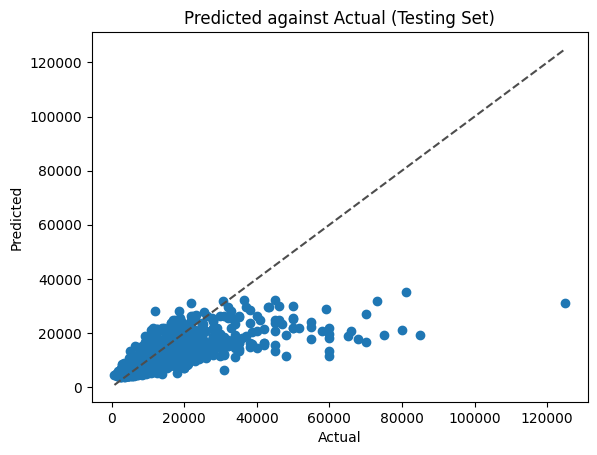

In [15]:
model = RandomForestRegressor(n_estimators=cv.best_params_["n_estimators"], 
                              max_depth=cv.best_params_["max_depth"],
                              max_features=cv.best_params_["max_features"],
                              criterion=cv.best_params_["criterion"],
                              random_state=42)
model.fit(X_train, y_train)
print(f"training r2: {model.score(X_train, y_train)}")
print(f"testing r2: {model.score(X_test, y_test)}")
pred = model.predict(X_test)
results = pd.DataFrame({"true_values": y_test, "predictions": pred})
results["error"] = results["true_values"] - results["predictions"]
print(f"""
score   = {model.score(X_test, y_test)}
r2      = {r2_score(y_test, pred)}
MAE     = {mean_absolute_error(y_test, pred)}
RMSE    = {mean_squared_error(y_test, pred, squared=False)}
MSE     = {mean_squared_error(y_test, pred)}
MAE %   = {mean_absolute_percentage_error(y_test, pred)}
""")

plt.scatter(y_test, pred)
diag_line_lower, diag_line_upper = min(min(y_test), min(pred)), max(max(y_test), max(pred))
plt.plot([diag_line_lower, diag_line_upper], [diag_line_lower, diag_line_upper], ls="--", c=".3")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted against Actual (Testing Set)")

### Feature Importance Plot

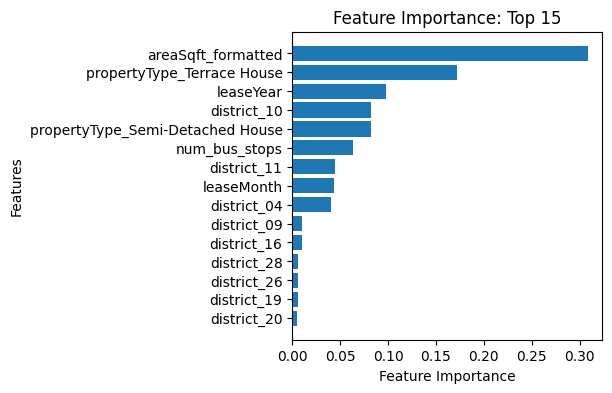

In [16]:
feature_importances = pd.DataFrame({"Feature": X_train.columns, "Importance": model.feature_importances_}).sort_values("Importance")
nonzero_feature_importances = feature_importances[feature_importances["Importance"] != 0].reset_index(drop=True)

plt.figure(figsize=(4, 4))
plt.barh(nonzero_feature_importances["Feature"][-15:], nonzero_feature_importances["Importance"][-15:])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance: Top 15')
plt.show()

### Run RF on Selected Features

In [17]:
nonzero_feature_importances.sort_values("Importance", ascending=False)["Feature"]

29                  areaSqft_formatted
28          propertyType_Terrace House
27                           leaseYear
26                         district_10
25    propertyType_Semi-Detached House
24                       num_bus_stops
23                         district_11
22                          leaseMonth
21                         district_04
20                         district_09
19                         district_16
18                         district_28
17                         district_26
16                         district_19
15                         district_20
14                         district_15
13                         district_25
12                         district_21
11                         district_23
10                         district_13
9                          district_14
8                          district_27
7                          district_05
6                          district_02
5                          district_17
4                        

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'criterion': 'absolute_error', 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 14, 'random_state': 42}
training r2: 0.6272283145070761
testing r2: 0.6065294848662084

score   = 0.6065294848662084
r2      = 0.6065294848662084
MAE     = 2459.703169288549
RMSE    = 4780.189730012474
MSE     = 22850213.854916725
MAE %   = 0.26212305627902116



Text(0.5, 1.0, 'Predicted against Actual (Testing Set)')

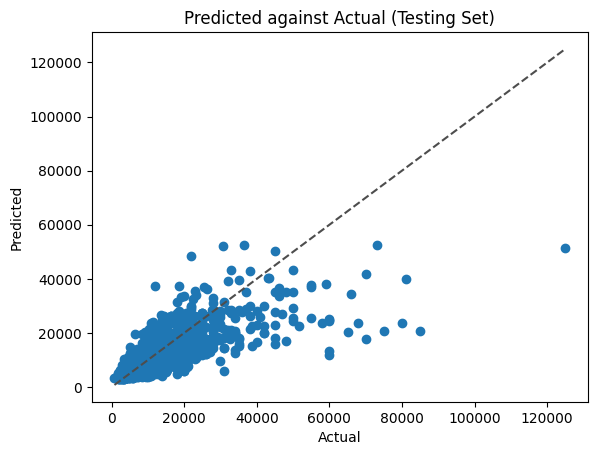

In [18]:
selected_features = [
              "areaSqft_formatted",
      "propertyType_Terrace House",
                       "leaseYear",
                     "district_10",
"propertyType_Semi-Detached House",
                   "num_bus_stops",
                     "district_11",
                      "leaseMonth",
                     "district_04",
]
select_X_train = X_train[selected_features]
select_X_test = X_test[selected_features]


# Define the hyperparameters grid for grid search
param_grid = {'n_estimators': np.arange(8, 15, 2),
            'max_depth' : [9],
            'max_features': ['log2'],
            'criterion' :['absolute_error'],
            'random_state': [42]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Evaluate multiple metrics
    cv=5,                              # Number of cross-validation folds
    verbose=1,
    n_jobs=-1
)

# Fit the grid search to the training data
grid_search.fit(select_X_train, y_train)

# Get the best model and its hyperparameters
selection_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_params)
model = RandomForestRegressor(n_estimators=best_params["n_estimators"], 
                              max_depth=best_params["max_depth"],
                              max_features=best_params["max_features"],
                              criterion=best_params["criterion"],
                              random_state=42)
model.fit(select_X_train, y_train)
print(f"training r2: {model.score(select_X_train, y_train)}")
print(f"testing r2: {model.score(select_X_test, y_test)}")
pred = model.predict(select_X_test)
results = pd.DataFrame({"true_values": y_test, "predictions": pred})
results["error"] = results["true_values"] - results["predictions"]
print(f"""
score   = {model.score(select_X_test, y_test)}
r2      = {r2_score(y_test, pred)}
MAE     = {mean_absolute_error(y_test, pred)}
RMSE    = {mean_squared_error(y_test, pred, squared=False)}
MSE     = {mean_squared_error(y_test, pred)}
MAE %   = {mean_absolute_percentage_error(y_test, pred)}
""")

plt.scatter(y_test, pred)
diag_line_lower, diag_line_upper = min(min(y_test), min(pred)), max(max(y_test), max(pred))
plt.plot([diag_line_lower, diag_line_upper], [diag_line_lower, diag_line_upper], ls="--", c=".3")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted against Actual (Testing Set)")


## Non-Landed

In [19]:
X_features = list(nonlanded_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent',]:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
print(X_features)
for col in ['leaseQuarter', 'noOfBedRoom']:
    # remove cols causing high colinearity
    X_features.remove(col)

X_train, X_test, y_train, y_test = train_test_split(nonlanded_encoded[X_features], nonlanded_encoded["rent"], test_size=0.2, random_state=42)

['noOfBedRoom', 'areaSqft_formatted', 'leaseYear', 'leaseQuarter', 'leaseMonth', 'num_bus_stops', 'median', 'district_02', 'district_03', 'district_04', 'district_05', 'district_06', 'district_07', 'district_08', 'district_09', 'district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_15', 'district_16', 'district_17', 'district_18', 'district_19', 'district_20', 'district_21', 'district_22', 'district_23', 'district_25', 'district_26', 'district_27', 'district_28', 'propertyType_Non-landed Properties']


training r2: 0.6661878620985677
testing r2: 0.6597628945681853

score   = 0.6597628945681853
r2      = 0.6597628945681853
MAE     = 857.3635909142929
RMSE    = 1595.4198227380775
MSE     = 2545364.4107855987
MAE %   = 0.18348912418557042



Text(0.5, 1.0, 'Predicted against Actual (Testing Set)')

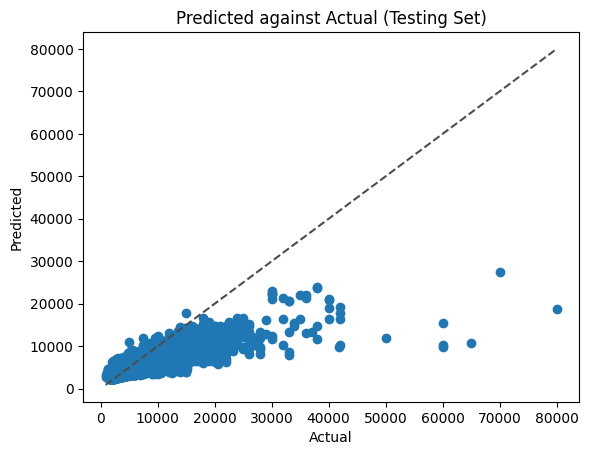

In [20]:
model = RandomForestRegressor(n_estimators=14,
                              max_depth=9,
                              max_features='log2',
                              criterion='absolute_error',
                              random_state=42)
model.fit(X_train, y_train)
print(f"training r2: {model.score(X_train, y_train)}")
print(f"testing r2: {model.score(X_test, y_test)}")
pred = model.predict(X_test)
results = pd.DataFrame({"true_values": y_test, "predictions": pred})
results["error"] = results["true_values"] - results["predictions"]
print(f"""
score   = {model.score(X_test, y_test)}
r2      = {r2_score(y_test, pred)}
MAE     = {mean_absolute_error(y_test, pred)}
RMSE    = {mean_squared_error(y_test, pred, squared=False)}
MSE     = {mean_squared_error(y_test, pred)}
MAE %   = {mean_absolute_percentage_error(y_test, pred)}
""")

plt.scatter(y_test, pred)
diag_line_lower, diag_line_upper = min(min(y_test), min(pred)), max(max(y_test), max(pred))
plt.plot([diag_line_lower, diag_line_upper], [diag_line_lower, diag_line_upper], ls="--", c=".3")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted against Actual (Testing Set)")

### Feature Importance Plot

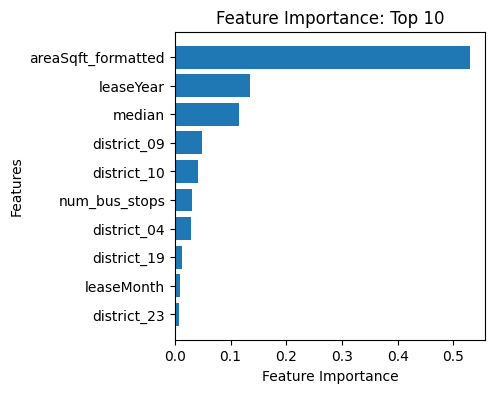

In [21]:
feature_importances = pd.DataFrame({"Feature": X_train.columns, "Importance": model.feature_importances_}).sort_values("Importance")
nonzero_feature_importances = feature_importances[feature_importances["Importance"] != 0].reset_index(drop=True)

plt.figure(figsize=(4,4))
plt.barh(nonzero_feature_importances["Feature"][-10:], nonzero_feature_importances["Importance"][-10:])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance: Top 10')
plt.show()

### Run RF on Selected Features

In [23]:
nonzero_feature_importances.sort_values("Importance", ascending=False)["Feature"]

31                    areaSqft_formatted
30                             leaseYear
29                                median
28                           district_09
27                           district_10
26                         num_bus_stops
25                           district_04
24                           district_19
23                            leaseMonth
22                           district_23
21                           district_14
20                           district_18
19                           district_17
18                           district_03
17                           district_16
16                           district_12
15                           district_21
14                           district_11
13                           district_27
12                           district_13
11                           district_15
10                           district_07
9     propertyType_Non-landed Properties
8                            district_05
7               

training r2: 0.8183590837998963
testing r2: 0.8131618615770524

score   = 0.8131618615770524
r2      = 0.8131618615770524
MAE     = 646.4842593317633
RMSE    = 1182.2706601416965
MSE     = 1397763.9138318826
MAE %   = 0.14453156436816014



Text(0.5, 1.0, 'Predicted against Actual (Testing Set)')

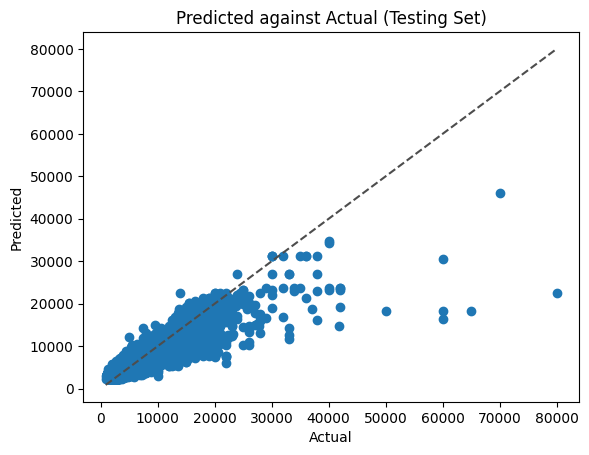

In [24]:
selected_features = [
"areaSqft_formatted",
         "leaseYear",
            "median",
       "district_09",
       "district_10",
     "num_bus_stops",
       "district_04",
]
select_X_train = X_train[selected_features]
select_X_test = X_test[selected_features]

model = RandomForestRegressor(n_estimators=14,
                              max_depth=9,
                              max_features='log2',
                              criterion='absolute_error',
                              random_state=42)


model.fit(select_X_train, y_train)
print(f"training r2: {model.score(select_X_train, y_train)}")
print(f"testing r2: {model.score(select_X_test, y_test)}")
pred = model.predict(select_X_test)
results = pd.DataFrame({"true_values": y_test, "predictions": pred})
results["error"] = results["true_values"] - results["predictions"]
print(f"""
score   = {model.score(select_X_test, y_test)}
r2      = {r2_score(y_test, pred)}
MAE     = {mean_absolute_error(y_test, pred)}
RMSE    = {mean_squared_error(y_test, pred, squared=False)}
MSE     = {mean_squared_error(y_test, pred)}
MAE %   = {mean_absolute_percentage_error(y_test, pred)}
""")

plt.scatter(y_test, pred)
diag_line_lower, diag_line_upper = min(min(y_test), min(pred)), max(max(y_test), max(pred))
plt.plot([diag_line_lower, diag_line_upper], [diag_line_lower, diag_line_upper], ls="--", c=".3")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted against Actual (Testing Set)")
